In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, radon, iradon
from skimage.filters import gaussian
import scipy
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.optimize import root, leastsq
from PIL import Image
import sys


In [2]:
def plot(plots, figsize=(10,10)):
    plt.figure(figsize=figsize)
    z = zip(plots)
    a = len(plots)
    b = list(range(a))
    for i in range(a):
        n = next(z)
        plt.subplot(int((a/2)*100+21+b[i]))
        #snr = entropy(n[0],rectangle(n[0].shape[0],n[0].shape[1])) #np.mean(n[0])/np.std(n[0])
        #plt.title('SNR = ' + str(snr)[0:5])
        plt.imshow(n[0])
    plt.show()

def threshold_plot(plot, amount):
    plot = plot - (np.mean(plot)-np.std(plot)/amount)
    plot = np.asarray([0 if i <0 else i for i in plot])
    return plot

def add_noise(array, mean, std, multiplier):
    noise = np.random.normal(mean, std ,array.shape)*multiplier
    array = array+noise-np.min(noise)
    array = np.array(((array-np.min(array))/np.max(array))*(2**16), dtype=np.uint16)
    #array += (np.random.poisson(lam=25, size=array.shape) - 10) / 255.
    return array


In [12]:
imshape = 512
im = (imshape,imshape)
offset = 0#int(imshape/10)+300
posa = int(imshape/2)-int(512/2)+offset
posb = int(imshape/2)+int(512/2)+offset

noise = 500
#Load Shepp Logan Phantom
slp = np.asarray(plt.imread('./pictures/Shepp-Logan_Phantom.tif')[:,:], dtype= float)

#Create space for offsetting phantom
phantom=np.zeros(im)
'''
if posa > phantom.shape[0] or posb>phantom.shape[1]:
    phantom = slp[len(slp)-offset:len(slp)+offset,len(slp)-offset:len(slp)+offset]
else:
    phantom[posa:posb,posa:posb] = slp
'''
phantom = slp[int(512/2)-int(imshape/2):int(512/2)+int(imshape/2),int(512/2)-int(imshape/2):int(512/2)+int(imshape/2)]
#number_angles = 1000

(482, 500)
65536.0 65522 2.06207285164173 4.558620420594689


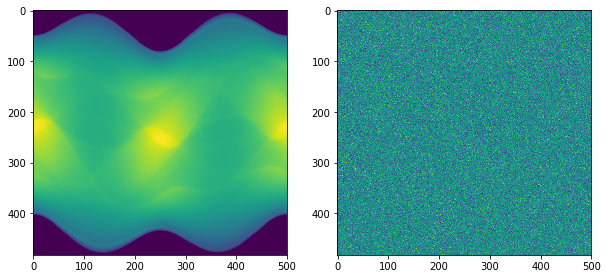

In [13]:
'''
Circle = False
theta = np.linspace(0., 360, number_angles, endpoint=False)

sinogram = radon(phantom, theta=theta, circle=Circle)
np.save('sinogram2', sinogram)
'''
sinogram = np.load('sinogram_off_center.npy')
sinogram = sinogram*2**16/np.max(sinogram)
sinogram_noise = add_noise(sinogram,np.mean(sinogram),np.std(sinogram), noise)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(sinogram)
plt.subplot(122)
plt.imshow(sinogram_noise)
plt.show
# In[145]:
print(sinogram.shape)
snr = lambda x: np.mean(x)/np.std(x)
print(np.max(sinogram), np.max(sinogram_noise), snr(sinogram), snr(sinogram_noise))

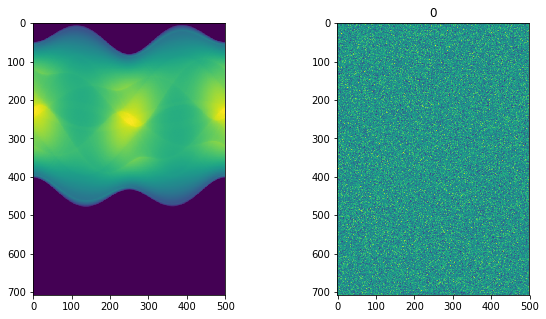

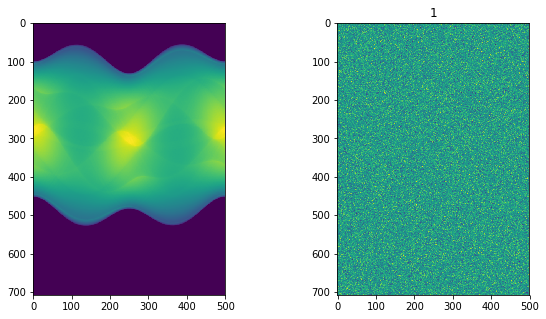

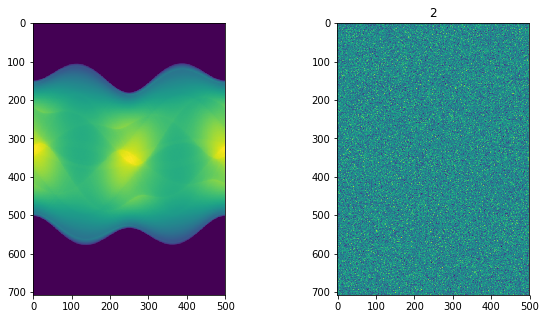

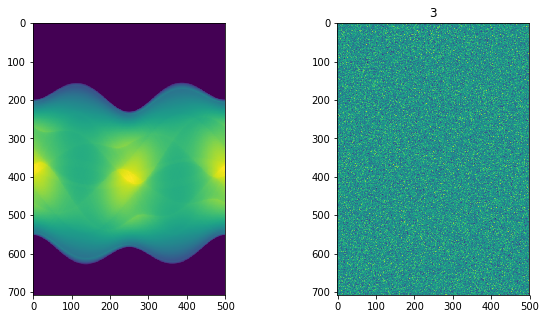

In [29]:
reals_odd = []
reals_even= []
imag_even = []
imag_odd = []
j = iter(list(range(50)))
shifting_range = sinogram.shape[0]-300
for i in range(shifting_range):
    #shift sinogram so rotation center is off of image center and add noise
    sinogram_shift_noiseless = np.zeros((int(sinogram.shape[0]*2-256),sinogram.shape[1]))
    sinogram_shift_noiseless[i:i+sinogram.shape[0],:] = sinogram

    sinogram_shift = add_noise(sinogram_shift_noiseless,np.mean(sinogram),np.std(sinogram), noise)
    if i %50==0:
        a = next(j)
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.imshow(sinogram_shift_noiseless)
        plt.subplot(122)
        plt.imshow(sinogram_shift)
        plt.title(str(a))
        plt.show()
        
    #Mess around with increasing dynamic range
    #sinogram_resized = resize(sinogram_shift, (int(sinogram_shift.shape[0] / 2), int(sinogram_shift.shape[1] / 1)), clip=False)

    resize_factor = 2
    sinogram_resized = np.zeros((int(sinogram_shift.shape[0]/resize_factor),int(sinogram_shift.shape[1])))
    for i in range(sinogram_resized.shape[0]):
        sinogram_resized[i,:] = sinogram_shift[i*resize_factor,:]+sinogram_shift[i*resize_factor+1,:]
    
    snr = np.mean(sinogram_shift)/np.std(sinogram_shift)
    #sum projections from sinogram to find rotation center (sym center)

    threshold_amount = snr #increase threshold to remove off-feature noise
    fft_cutoff = 5 #decrease fft cutoff to reduce high frequencies

    rowsum = threshold_plot(np.sum(sinogram_shift, axis=1),threshold_amount)
    #var = threshold_plot(np.std(sinogram_shift, axis=1),threshold_amount)
    #mean = threshold_plot(np.mean(sinogram_shift, axis=1),threshold_amount)


    #sum for interpolated image
    rowsum2 = threshold_plot(np.sum(sinogram_resized, axis=1),threshold_amount)
    #var2 = threshold_plot(np.std(sinogram_resized, axis=1),threshold_amount)
    #mean2 = threshold_plot(np.mean(sinogram_resized, axis=1),threshold_amount)

    #fft for row sum
    fft = np.fft.fft(np.sum(sinogram_shift, axis=1))
    #plt.plot(fft[0:10])
    plt.show()
    fft[fft_cutoff:]=0+0j
    ifft = threshold_plot(np.fft.ifft(fft),threshold_amount)

    fft2 = np.fft.fft(np.sum(sinogram_resized, axis=1))
    fft2[fft_cutoff:]=0
    ifft2 = threshold_plot(np.fft.ifft(fft2),threshold_amount)

    #Center of Mass (COM) guess at root
    COM = scipy.ndimage.measurements.center_of_mass(np.real(ifft))[0]/len(ifft)*sinogram_shift.shape[0]
    COM2 = scipy.ndimage.measurements.center_of_mass(np.real(ifft2))[0]/len(ifft2)*sinogram_resized.shape[0]


    r = np.arange(0,sinogram_shift.shape[0],resize_factor)#sinogram_resized.shape[0])

    #Rethreshold to lower level and include more data
    threshold_amount = None#increase threshold to remove off-feature noise
    fft_cutoff = 50 #decrease fft cutoff to reduce high frequencies
    fft_threshold = None
    r0_even = []
    r0_odd = []

    #Use COM to guess root
    rowsum_grad = np.sum(sinogram_shift, axis=1)

    #fft for row sum
    fft = np.fft.fft(rowsum_grad) #np.sum(sinogram_shift, axis=1))
    fft_even = np.ones(fft.shape)*0+0j
    fft_odd = np.ones(fft.shape)*0+0j
    num_components = 1
    for i in range(num_components):
        fft_even[i*2]=fft[i*2]
        fft_odd[i*2+1]=fft[i*2+1]
        
    #fft_even[200:]=0+0j
    #fft_odd[200:]=0+0j

    #Interpolate function and guess root
    ifft_even = np.fft.ifft(fft_even)#threshold_plot(np.fft.ifftshift((np.fft.ifft(fft))),fft_threshold)
    ifft_odd = np.fft.ifft(fft_odd)
    #ifft_odd = threshold_plot((np.fft.ifft(fft_odd)),fft_threshold)
    x = np.arange(0,len(np.gradient(np.real(ifft_even)))*2,2)
    f2_even = CubicSpline(x, np.gradient(np.imag(ifft_even)))
    f2_odd = CubicSpline(x, np.gradient(np.imag(ifft_odd)))
    r0_even = root(f2_even,COM)['x'][0]
    r0_odd = root(f2_odd,COM)['x'][0]
    reals_even.append(np.sum(np.real(fft_even)))
    reals_odd.append(np.sum(np.real(fft_odd)))
    imag_even.append(np.sum(np.imag(fft_even)))
    imag_odd.append(np.sum(np.imag(fft_odd)))
    
plt.show()


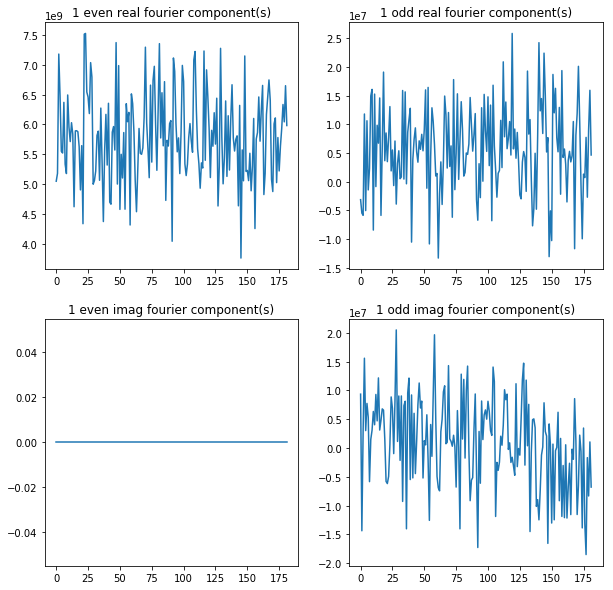

uint16 65492 0


In [30]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title(str(num_components) + ' even real fourier component(s)')
plt.plot(reals_even)
plt.subplot(222)
plt.title(str(num_components) + ' odd real fourier component(s)')
plt.plot(reals_odd)

plt.subplot(223)
plt.title(str(num_components) + ' even imag fourier component(s)')
plt.plot(imag_even)
plt.subplot(224)
plt.title(str(num_components) + ' odd imag fourier component(s)')
plt.plot(imag_odd)

plt.show()

print(sinogram_shift.dtype, np.max(sinogram_shift), np.min(sinogram_shift))

# Fit odd component to sine curve

/home/everett/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


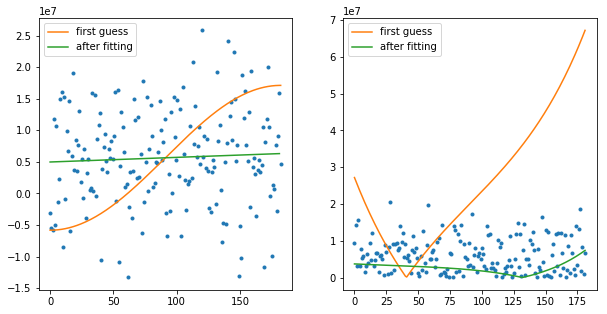

In [31]:
N = len(reals_odd) # number of data points
t = np.linspace(0, N, N)
#f = None # Optional!! Advised not to use
data = np.asarray(reals_odd) # create artificial data with noise
data_linear = np.asarray(imag_odd)

guess_mean = np.mean(data)
guess_std = 3*np.std(data)/(2**0.5)/(2**0.5)
guess_phase = -np.pi/2
guess_freq = np.pi/(N)
guess_amp = np.max(data)

guess_mean2 = 20000000.
guess_std2 = 3*np.std(data_linear)/(2**0.5)/(2**0.5)
guess_phase2 = -np.pi/2
guess_freq2 = np.pi/(N)
guess_amp2 = np.max(data_linear)

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(guess_freq*t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda x: x[0]*np.cosh(x[1]*t+x[2]) + x[3] - data
est_amp, est_freq, est_phase, est_mean= leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
data_linear = np.asarray(imag_odd)
guess_slope = 10
guess_intercept = -4
s = t
optimize_linear = lambda y: y[0]*np.sinh(y[1]*s + y[2])+ y[3] - data_linear
est_amp2, est_freq2, est_phase2, est_mean2 = leastsq(optimize_linear, [guess_amp2, guess_freq2, guess_phase2, guess_mean2])[0]

# recreate the fitted curve using the optimized parameters

fine_t = np.arange(0,N,1)
data_fit=est_amp*np.cosh(est_freq*fine_t+est_phase)+est_mean

data_fit_linear = est_amp2*np.sinh(est_freq2*s+ est_phase2)+ est_mean2
data_first_guess_linear = guess_amp2*np.sinh(guess_freq2*s+ guess_phase2)+ guess_mean2

plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(t, data, '.')
plt.plot(t, data_first_guess, label='first guess')
plt.plot(fine_t, data_fit, label='after fitting')
plt.legend()

plt.subplot(122)
plt.plot(np.abs(data_linear), '.')
plt.plot(np.abs(data_first_guess_linear), label='first guess')
plt.plot(fine_t, np.abs(data_fit_linear), label='after fitting')
plt.legend()

plt.show()

In [32]:
x_range = np.linspace(0,N, 1)
fit = est_amp*np.sin(est_freq*x_range+est_phase)+est_mean


fft_odd_max = argrelextrema(abs(data_fit), np.greater)[0]
fft_odd_imag_min = argrelextrema(abs(data_fit_linear), np.less)[0]

print(sinogram_shift.shape[0]/2)
print(fft_odd_max)#*sinogram_shift.shape[0]/shifting_range)


print(fft_odd_imag_min)

354.0
[]
[132]


In [33]:
print(sinogram.shape[0]/2+fft_odd_max)
print(sinogram.shape[0]/2+fft_odd_imag_min)

[]
[373.]


In [19]:
np.min((np.random.poisson(lam=25, size=sinogram.shape) - 10) / 255.)



-0.01568627450980392

In [20]:
est_amp2, est_freq2, est_phase2, est_mean2

(5807618.112211134,
 0.004748542382202053,
 0.3716854875857285,
 -5862394.265729624)